<a href="https://colab.research.google.com/github/hadif1999/iot_smoke_detection_ML/blob/main/smoke_detection_iot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#smoke_detection_iot project

# Preprocessing


In this section, data are loaded, inspected, and cleaned. Correlation is checked, outliers are removed, and missing values are verified before modeling.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow.keras as tfk
import os

In [3]:
import os
import random
import tensorflow as tf

os.environ["PYTHONHASHSEED"] = "42"
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)


In [4]:
import requests

# Replace with the actual raw GitHub URL of your CSV file
github_csv_url = "https://raw.githubusercontent.com/hadif1999/iot_smoke_detection_ML/main/smoke_detection_iot.csv"

response = requests.get(github_csv_url)
response.raise_for_status()  # Raise an HTTPError for bad responses (4xx or 5xx)

with open("smoke_detection_iot.csv", "wb") as f:
    f.write(response.content)

print("Dataset downloaded successfully to smoke_detection_iot.csv")

Dataset downloaded successfully to smoke_detection_iot.csv


In [5]:

data = pd.read_csv("smoke_detection_iot.csv")
data

,Unnamed: 0,UTC,Temperature[C],Humidity[%],TVOC[ppb],eCO2[ppm],Raw H2,Raw Ethanol,Pressure[hPa],PM1.0,PM2.5,NC0.5,NC1.0,NC2.5,CNT,Fire Alarm
0,0,1654733331,20.000,57.36,0,400,12306,18520,939.735,0.00,0.00,0.00,0.000,0.000,0,0
1,1,1654733332,20.015,56.67,0,400,12345,18651,939.744,0.00,0.00,0.00,0.000,0.000,1,0
2,2,1654733333,20.029,55.96,0,400,12374,18764,939.738,0.00,0.00,0.00,0.000,0.000,2,0
3,3,1654733334,20.044,55.28,0,400,12390,18849,939.736,0.00,0.00,0.00,0.000,0.000,3,0
4,4,1654733335,20.059,54.69,0,400,12403,18921,939.744,0.00,0.00,0.00,0.000,0.000,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62625,62625,1655130047,18.438,15.79,625,400,13723,20569,936.670,0.63,0.65,4.32,0.673,0.015,5739,0
62626,62626,1655130048,18.653,15.87,612,400,13731,20588,936.678,0.61,0.63,4.18,0.652,0.015,5740,0
62627,62627,1655130049,18.867,15.84,627,400,13725,20582,936.687,0.57,0.60,3.95,0.617,0.014,5741,0
62628,62628,1655130050,19.083,16.04,638,400,13712,20566,936.680,0.57,0.59,3.92,0.611,0.014,5742,0


Columns explanation :
<br>
Air Temperature
<br>
Air Humidity
<br>

TVOC: Total Volatile Organic Compounds; measured in parts per billion (Source)
<br>
eCO2: co2 equivalent concentration; calculated from different values like TVCO
<br>
Raw H2: raw molecular hydrogen; not compensated (Bias, temperature, etc.)
<br>
Raw Ethanol: raw ethanol gas (Source)¶
<br>
PM 1.0 and PM 2.5: particulate matter size < 1.0 µm (PM1.0). 1.0 µm < 2.5 µm (PM2.5)
<br>
Fire Alarm: ground truth is "1" if a fire is there
<br>
CNT: Sample counter
<br>
UTC: Timestamp UTC seconds
<br>
NC0.5/NC1.0 and NC2.5: Number concentration of particulate matter. This differs from PM because NC gives the actual number of particles in the air.
<br>
The raw NC is also classified by the particle size: < 0.5 µm (NC0.5); 0.5 µm < 1.0 µm (NC1.0); 1.0 µm < 2.5 µm (NC2.5)¶

<Axes: >

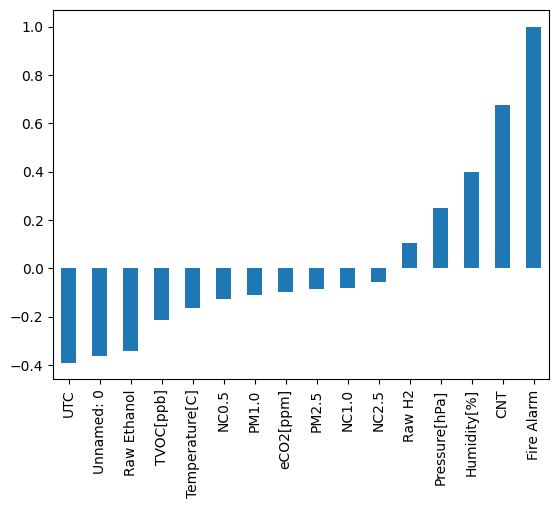

In [6]:
data.corr()["Fire Alarm"].sort_values().plot(kind='bar')

In [7]:
cols = ['Unnamed: 0',"PM2.5" , 'CNT' ,
             'UTC' , "Raw H2",
       'PM1.0' , 'NC0.5' ,'NC1.0' ,'NC2.5']

In [8]:
data2 = data.copy()
data2.drop(cols, axis=1, inplace=True)
data2

,Temperature[C],Humidity[%],TVOC[ppb],eCO2[ppm],Raw Ethanol,Pressure[hPa],Fire Alarm
0,20.000,57.36,0,400,18520,939.735,0
1,20.015,56.67,0,400,18651,939.744,0
2,20.029,55.96,0,400,18764,939.738,0
3,20.044,55.28,0,400,18849,939.736,0
4,20.059,54.69,0,400,18921,939.744,0
...,...,...,...,...,...,...,...
62625,18.438,15.79,625,400,20569,936.670,0
62626,18.653,15.87,612,400,20588,936.678,0
62627,18.867,15.84,627,400,20582,936.687,0
62628,19.083,16.04,638,400,20566,936.680,0


,0
Temperature[C],"Axes(0.125,0.798085;0.133621x0.0819149)"
Humidity[%],"Axes(0.285345,0.798085;0.133621x0.0819149)"
TVOC[ppb],"Axes(0.44569,0.798085;0.133621x0.0819149)"
eCO2[ppm],"Axes(0.606034,0.798085;0.133621x0.0819149)"
Raw Ethanol,"Axes(0.766379,0.798085;0.133621x0.0819149)"
Pressure[hPa],"Axes(0.125,0.699787;0.133621x0.0819149)"
Fire Alarm,"Axes(0.285345,0.699787;0.133621x0.0819149)"


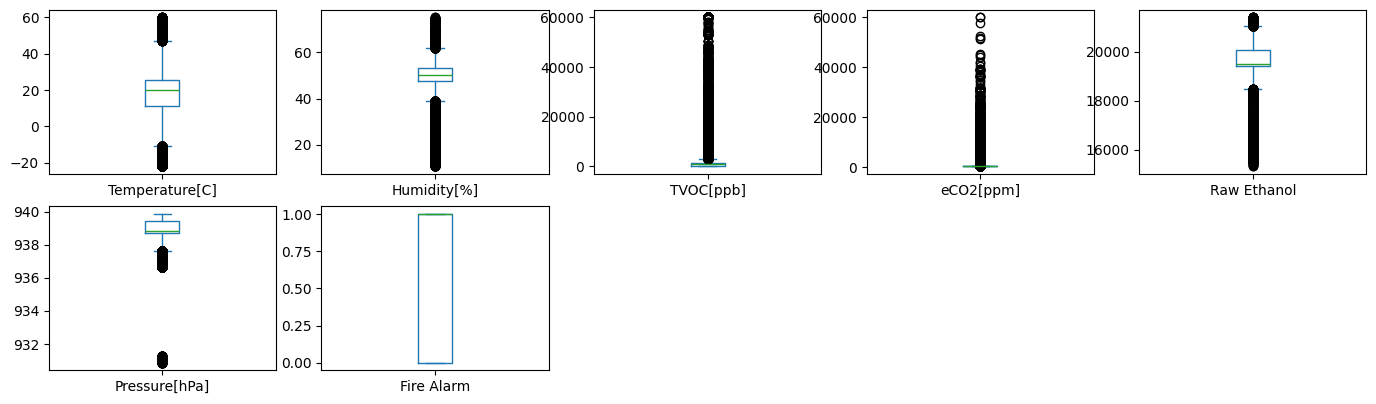

In [9]:
data2.plot(kind='box', subplots=True, layout=(8,5), figsize=(17,20))

In [10]:
def outlier_bands(df, multiplier: int = 1.5):

 Q1 = df.quantile(0.25)
 Q3 = df.quantile(0.75)

 IQR = Q3-Q1
 lower_band = Q1 - multiplier*IQR
 upper_band = Q3 + multiplier*IQR


 return lower_band,upper_band




In [11]:
low_band, up_band = outlier_bands(data2, multiplier=2)

data_clean = data2.copy()

# Create a boolean mask to identify rows with outliers
# A row is an outlier if any of its values are either greater than the upper band
# or less than the lower band for the respective column.
outlier_mask = ((data_clean > up_band) | (data_clean < low_band)).any(axis=1)

# Filter out the outlier rows
data_clean = data_clean[~outlier_mask]

print(f"Removed {len(data2) - len(data_clean)} outlier rows.")

Removed 15173 outlier rows.


**Note on Outlier Removal**
Outliers are removed using bounds computed on the full dataset. This can introduce leakage in strict evaluation, but it is retained here to preserve consistency with the current results.


In [12]:
data_clean.shape, data2.shape

((47457, 7), (62630, 7))

In [13]:
data_clean = data_clean.reset_index(drop = True)
#data_clean.drop(["level_0","index"],axis=1,inplace=True)
data_clean

,Temperature[C],Humidity[%],TVOC[ppb],eCO2[ppm],Raw Ethanol,Pressure[hPa],Fire Alarm
0,20.000,57.36,0,400,18520,939.735,0
1,20.015,56.67,0,400,18651,939.744,0
2,20.029,55.96,0,400,18764,939.738,0
3,20.044,55.28,0,400,18849,939.736,0
4,20.059,54.69,0,400,18921,939.744,0
...,...,...,...,...,...,...,...
47452,13.430,45.55,0,400,21178,937.325,0
47453,13.443,45.74,0,400,21162,937.314,0
47454,13.455,45.89,0,400,21154,937.300,0
47455,13.467,45.96,0,400,21143,937.284,0


In [14]:
data_clean.describe().T

,count,mean,std,min,25%,50%,75%,max
Temperature[C],47457.0,15.672483,12.104503,-17.832,12.033,19.88,25.100,30.100
Humidity[%],47457.0,50.192783,4.014264,37.900,47.730,50.31,53.260,64.650
TVOC[ppb],47457.0,618.774659,550.390443,0.000,88.000,316.00,1180.000,1490.000
eCO2[ppm],47457.0,410.377563,21.131387,400.000,400.000,400.00,411.000,514.000
Raw Ethanol,47457.0,19857.978697,466.236737,18520.000,19435.000,19898.00,20122.000,21362.000
Pressure[hPa],47457.0,938.876311,0.748556,937.278,938.706,938.80,939.617,939.861
Fire Alarm,47457.0,0.704448,0.456295,0.000,0.000,1.00,1.000,1.000


In [15]:
y = data_clean["Fire Alarm"]

In [16]:
y = y.values
y

array([0, 0, 0, ..., 0, 0, 0])

In [17]:
# Data profiling: missing values and class balance
missing_summary = data_clean.isnull().sum()
print("Missing values per column:")
print(missing_summary)

print("")
print("Class balance (Fire Alarm):")
class_counts = data_clean["Fire Alarm"].value_counts().sort_index()
class_perc = (class_counts / class_counts.sum() * 100).round(2)
class_balance = pd.DataFrame({"Count": class_counts, "Percent": class_perc})
class_balance


Missing values per column:
Temperature[C]    0
Humidity[%]       0
TVOC[ppb]         0
eCO2[ppm]         0
Raw Ethanol       0
Pressure[hPa]     0
Fire Alarm        0
dtype: int64

Class balance (Fire Alarm):


,Count,Percent
Fire Alarm,,
0,14026,29.56
1,33431,70.44


In [18]:
x = data_clean[["Temperature[C]","Humidity[%]","TVOC[ppb]","eCO2[ppm]","Raw Ethanol","Pressure[hPa]"]].values

In [19]:
feature_names = ["Temperature[C]", "Humidity[%]", "TVOC[ppb]", "eCO2[ppm]", "Raw Ethanol", "Pressure[hPa]"]


# Neural Network (MLP)


A simple feed-forward neural network is trained and evaluated first with a holdout split, then with K-fold cross-validation.


## Holdout Training and Evaluation


In [20]:
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [21]:
X_train, X_test, Y_train, Y_test = train_test_split(x,y,test_size=0.15, random_state=10)

In [22]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [34]:
# number of each label in test data

unique, counts = np.unique(Y_test, return_counts=True)
label_counts = dict(zip(unique, counts))

print("Number of 0s in Y_test:", label_counts.get(0, 0))
print("Number of 1s in Y_test:", label_counts.get(1, 0))

Number of 0s in Y_test: 2077
Number of 1s in Y_test: 5042


In [23]:

def model_gen ( n_HD_layer , n_neuron_list , input_shape = data_clean.shape[1:], ac_f = "sigmoid"):

  if not n_HD_layer == len(n_neuron_list) : print("number of hidden layers must be equal to len of list of number of neurons in each layer ")

  layer_list = []

  input_layer = tfk.layers.Input(input_shape,name = "input_layer")
  layer_list.append(input_layer)

  for i in range(n_HD_layer):

    hd_layer = tfk.layers.Dense(n_neuron_list[i], ac_f ,False,"glorot_normal",name = "hd_layer{}".format(i+1))(layer_list[-1])
    batch_layer = tfk.layers.BatchNormalization(name = "batch_layer{}".format(i+1))(hd_layer)
    drop_layer = tfk.layers.Dropout( 0.4 ,name = "drop_layer{}".format(i+1) )(batch_layer)

    layer_list.append(hd_layer)
    layer_list.append(batch_layer)
    layer_list.append(drop_layer)

  #drop_layer_final = tfk.layers.Dropout(0.4)(layer_list[-1])
  #layer_list.append(drop_layer_final)

  out_layer = tfk.layers.Dense(1,"sigmoid",False,name = "output_layer")(layer_list[-1])

  model = tfk.Model(inputs=input_layer , outputs =out_layer,name = "model01" )

  return model



In [24]:
model_args = dict(n_HD_layer=2 , n_neuron_list=[40, 20])

model1 = model_gen(**model_args, input_shape = X_train.shape[1:])
model1.summary()

Model: "model01"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 6)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hd_layer1 (Dense)               │ (None, 40)             │           240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_layer1                    │ (None, 40)             │           160 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop_layer1 (Dropout)           │ (None, 40)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hd_layer2 (Dense)               │ (None, 20)             │           800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_layer2                    │ (None, 20)             │            80 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop_layer2 (Dropout)           │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │            20 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,300 (5.08 KB)

 Trainable params: 1,180 (4.61 KB)

 Non-trainable params: 120 (480.00 B)

In [25]:
model1.compile(optimizer = "Adam", loss="binary_crossentropy",
               metrics = ["accuracy","binary_accuracy",
                          tfk.metrics.AUC(),tfk.metrics.Precision(),tfk.metrics.Recall()],)

In [26]:
hist1 = model1.fit(x = X_train, y = Y_train , batch_size = 24 , epochs = 3, validation_split=0.15)

Epoch 1/3
1429/1429 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.8279 - auc: 0.9026 - binary_accuracy: 0.8279 - loss: 0.3641 - precision: 0.9032 - recall: 0.8432 - val_accuracy: 0.9709 - val_auc: 0.9976 - val_binary_accuracy: 0.9709 - val_loss: 0.0695 - val_precision: 0.9846 - val_recall: 0.9741
Epoch 2/3
1429/1429 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9422 - auc: 0.9848 - binary_accuracy: 0.9422 - loss: 0.1426 - precision: 0.9561 - recall: 0.9619 - val_accuracy: 0.9721 - val_auc: 0.9980 - val_binary_accuracy: 0.9721 - val_loss: 0.0623 - val_precision: 0.9872 - val_recall: 0.9731
Epoch 3/3
1429/1429 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9477 - auc: 0.9877 - binary_accuracy: 0.9477 - loss: 0.1280 - precision: 0.9591 - recall: 0.9667 - val_accuracy: 0.9742 - val_auc: 0.9984 - val_binary_accuracy: 0.9742 - val_loss: 0.0611 - val_precision: 0.9910 - val_recall: 0.9724


## Training History Plots
Learning curves are plotted to visualize optimization progress (loss/metrics across epochs).


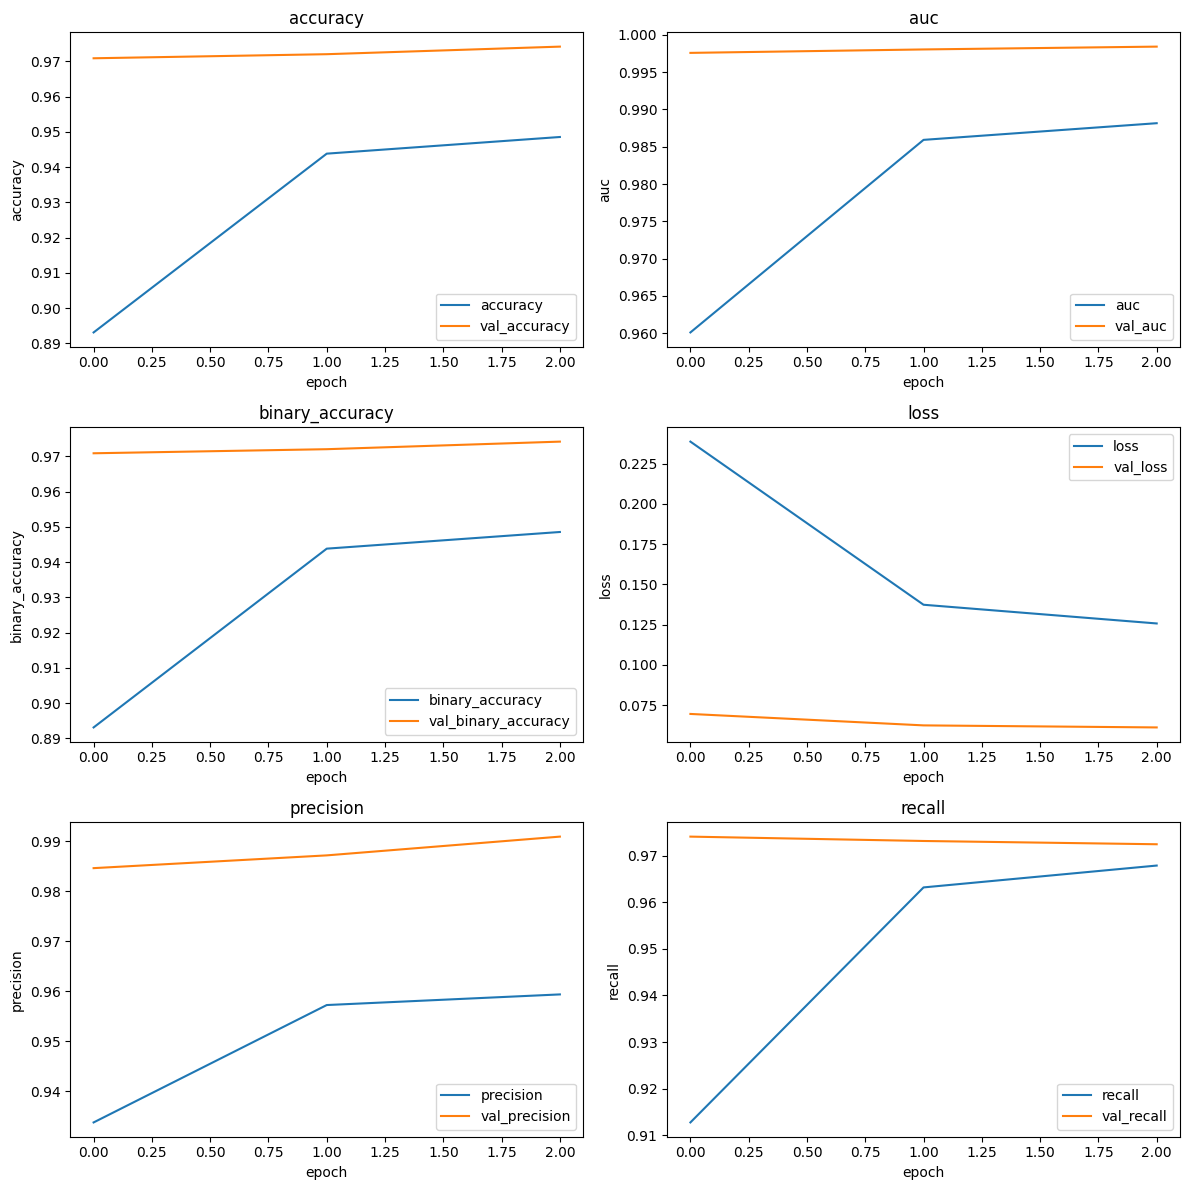

In [27]:
import math

history = hist1.history
metrics = [m for m in history.keys() if not m.startswith("val_")]

cols = 2
rows = math.ceil(len(metrics) / cols)
fig, axes = plt.subplots(rows, cols, figsize=(6 * cols, 4 * rows))
axes = axes.flatten() if hasattr(axes, "flatten") else [axes]

for i, m in enumerate(metrics):
    axes[i].plot(history[m], label=m)
    if f"val_{m}" in history:
        axes[i].plot(history[f"val_{m}"], label=f"val_{m}")
    axes[i].set_title(m)
    axes[i].set_xlabel("epoch")
    axes[i].set_ylabel(m)
    axes[i].legend()

# remove unused axes
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


In [28]:
model1.save("smoke_detection_iot.h5")

In [29]:
eval = model1.evaluate(X_test, Y_test)

223/223 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9709 - auc: 0.9976 - binary_accuracy: 0.9709 - loss: 0.0675 - precision: 0.9847 - recall: 0.9745


In [30]:
print("final accuracy for test data is : " , eval[1])

final accuracy for test data is :  0.9717656970024109


np.int64(5042)

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt

y_hat = model1.predict(X_test)
y_hat_ = np.round(y_hat.T[0])

# Generate the confusion matrix
cm = confusion_matrix(Y_test, y_hat_)

# Define class labels for clarity
class_labels = ['No Alarm', 'Alarm']

# Plotting the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=class_labels, yticklabels=class_labels)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

print("Confusion Matrix:\n", cm)
print("\nClassification Report:\n", classification_report(Y_test, y_hat_, target_names=class_labels))

## ROC Curve (Neural Network)
ROC is computed from the holdout test probabilities.


In [ ]:
fpr, tpr, _ = roc_curve(Y_test, y_hat)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"NN ROC (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], "--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Neural Network (Holdout)")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()


## K-Fold Cross-Validation (Neural Network)


In [ ]:
if not isinstance(y, np.ndarray):
    y = y.values

In [ ]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, shuffle=True, random_state=42)
print("KFold object 'kf' initialized successfully.")

In [ ]:
accuracy_scores = []
auc_scores = []
precision_scores = []
recall_scores = []
loss_scores = []

for fold, (train_index, val_index) in enumerate(kf.split(x)):
    print(f"\n--- Fold {fold+1}/{kf.n_splits} ---")
    # 3. Split the data into training and validation sets
    X_train_fold, X_val_fold = x[train_index], x[val_index]
    Y_train_fold, Y_val_fold = y[train_index], y[val_index]

    # 4 & 5. Instantiate StandardScaler and apply it
    sc = StandardScaler()
    X_train_fold = sc.fit_transform(X_train_fold)
    X_val_fold = sc.transform(X_val_fold)

    # 6. Create a new model instance for the current fold
    model_fold = model_gen(**model_args, input_shape=X_train_fold.shape[1:])

    # 7. Compile the new model
    model_fold.compile(optimizer="Adam", loss="binary_crossentropy",
                       metrics=["accuracy", "binary_accuracy",
                                  tfk.metrics.AUC(), tfk.metrics.Precision(), tfk.metrics.Recall()])

    # 8. Train the model
    history = model_fold.fit(x=X_train_fold, y=Y_train_fold, batch_size=24, epochs=3, verbose=1) # Set verbose to 0 to suppress output for each epoch

    # 9. Evaluate the trained model
    eval_metrics = model_fold.evaluate(X_val_fold, Y_val_fold, verbose=0)
    print(f"Fold {fold+1} Evaluation: Loss = {eval_metrics[0]:.4f}, Accuracy = {eval_metrics[1]:.4f}, AUC = {eval_metrics[3]:.4f}, Precision = {eval_metrics[4]:.4f}, Recall = {eval_metrics[5]:.4f}")

    # 10. Append the evaluated metrics to their respective lists
    loss_scores.append(eval_metrics[0])
    accuracy_scores.append(eval_metrics[1])
    auc_scores.append(eval_metrics[3]) # Assuming AUC is at index 3 based on compile metrics
    precision_scores.append(eval_metrics[4])
    recall_scores.append(eval_metrics[5]) # Assuming Recall is at index 5 based on compile metrics

print("\nK-fold cross-validation complete. Metrics stored.")

In [ ]:
print("Average Accuracy: {:.4f} (+/- {:.4f})".format(np.mean(accuracy_scores), np.std(accuracy_scores)))
print("Average AUC: {:.4f} (+/- {:.4f})".format(np.mean(auc_scores), np.std(auc_scores)))
print("Average Precision: {:.4f} (+/- {:.4f})".format(np.mean(precision_scores), np.std(precision_scores)))
print("Average Recall: {:.4f} (+/- {:.4f})".format(np.mean(recall_scores), np.std(recall_scores)))
print("Average Loss: {:.4f} (+/- {:.4f})".format(np.mean(loss_scores), np.std(loss_scores)))


# Support Vector Machine (SVM)


The same K-fold protocol is applied to a classical SVM baseline for comparison.


## K-Fold Cross-Validation (SVM)


In [ ]:
from sklearn.svm import SVC
svm_accuracy_scores = []
svm_precision_scores = []
svm_recall_scores = []
svm_f1_scores = []

all_y_true = []
all_y_pred_svm = []
all_y_score_svm = []

for fold, (train_index, val_index) in enumerate(kf.split(x)):
    print(f"\n--- SVM Fold {fold+1}/{kf.n_splits} ---")

    # Split the data
    X_train_fold, X_val_fold = x[train_index], x[val_index]
    Y_train_fold, Y_val_fold = y[train_index], y[val_index]

    # Scale the data
    sc_svm = StandardScaler()
    X_train_fold_scaled = sc_svm.fit_transform(X_train_fold)
    X_val_fold_scaled = sc_svm.transform(X_val_fold)

    # Instantiate a new SVC classifier
    svm_model_fold = SVC(random_state=42, C=0.5)

    # Train the SVM model
    svm_model_fold.fit(X_train_fold_scaled, Y_train_fold)

    # Make predictions
    y_pred_svm_fold = svm_model_fold.predict(X_val_fold_scaled)

    # Decision scores for ROC
    y_score_svm_fold = svm_model_fold.decision_function(X_val_fold_scaled)

    # Calculate metrics for the current fold
    report = classification_report(Y_val_fold, y_pred_svm_fold, output_dict=True)

    # Extract metrics for the positive class (class 1)
    accuracy_fold = report['accuracy']
    precision_fold = report['1']['precision']
    recall_fold = report['1']['recall']
    f1_fold = report['1']['f1-score']

    print(f"Fold {fold+1} Accuracy: {accuracy_fold:.4f}")
    print(f"Fold {fold+1} Precision (Class 1): {precision_fold:.4f}")
    print(f"Fold {fold+1} Recall (Class 1): {recall_fold:.4f}")
    print(f"Fold {fold+1} F1-Score (Class 1): {f1_fold:.4f}")

    # Append metrics to lists
    svm_accuracy_scores.append(accuracy_fold)
    svm_precision_scores.append(precision_fold)
    svm_recall_scores.append(recall_fold)
    svm_f1_scores.append(f1_fold)

    # Accumulate true and predicted labels
    all_y_true.extend(Y_val_fold)
    all_y_pred_svm.extend(y_pred_svm_fold)
    all_y_score_svm.extend(y_score_svm_fold)

print("\nSVM K-fold cross-validation complete. Metrics and predictions stored.")

## SVM Evaluation Summary
A consolidated set of metrics is computed from all folds to summarize SVM performance.


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

svm_accuracy = accuracy_score(all_y_true, all_y_pred_svm)
svm_precision = precision_score(all_y_true, all_y_pred_svm)
svm_recall = recall_score(all_y_true, all_y_pred_svm)
svm_f1 = f1_score(all_y_true, all_y_pred_svm)

print(f"SVM Accuracy:  {svm_accuracy:.4f}")
print(f"SVM Precision: {svm_precision:.4f}")
print(f"SVM Recall:    {svm_recall:.4f}")
print(f"SVM F1-Score:  {svm_f1:.4f}")

# store for comparison table
svm_summary = {
    "Accuracy": svm_accuracy,
    "Precision": svm_precision,
    "Recall": svm_recall,
    "F1": svm_f1,
}


## Metrics and Confusion Matrix for SVM
A consolidated classification report and confusion matrix are produced from all folds.


In [ ]:
print("Consolidated Classification Report for SVM (K-fold):")
print(classification_report(all_y_true, all_y_pred_svm, target_names=['No Alarm', 'Alarm']))

# Generate the consolidated confusion matrix
cm_svm_consolidated = confusion_matrix(all_y_true, all_y_pred_svm)

# Plotting the consolidated confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm_svm_consolidated, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['No Alarm', 'Alarm'], yticklabels=['No Alarm', 'Alarm'])

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Consolidated Confusion Matrix for SVM (K-fold)')
plt.show()

print("Consolidated Confusion Matrix (K-fold):\n", cm_svm_consolidated)


## ROC Curve (SVM)
ROC is computed from consolidated decision scores across folds.


In [ ]:
fpr_svm, tpr_svm, _ = roc_curve(all_y_true, all_y_score_svm)
roc_auc_svm = auc(fpr_svm, tpr_svm)

plt.figure(figsize=(6, 5))
plt.plot(fpr_svm, tpr_svm, label=f"SVM ROC (AUC = {roc_auc_svm:.4f})")
plt.plot([0, 1], [0, 1], "--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - SVM (K-Fold Consolidated)")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()


## SHAP Value Analysis



In [ ]:
try:
    import shap
except ImportError:
    print("SHAP is not installed. run pip install shap")
else:
    # Train a full SVM model for interpretability
    sc_full = StandardScaler()
    X_full_scaled = sc_full.fit_transform(x)

    svm_full = SVC(random_state=42, C=0.5, probability=True)
    svm_full.fit(X_full_scaled, y)

    # Sample data for faster SHAP computation
    sample_size = min(200, len(X_full_scaled))
    background_size = min(100, len(X_full_scaled))

    rng = np.random.default_rng(42)
    sample_idx = rng.choice(len(X_full_scaled), size=sample_size, replace=False)
    background_idx = rng.choice(len(X_full_scaled), size=background_size, replace=False)

    X_sample = X_full_scaled[sample_idx]
    background = X_full_scaled[background_idx]

    # Wrap predict_proba to return only the probability of the positive class (index 1)
    # This ensures explainer.shap_values returns a 2D array, which summary_plot expects directly.
    def model_predict_proba_wrapper(x_input):
        return svm_full.predict_proba(x_input)[:, 1]

    explainer = shap.KernelExplainer(model_predict_proba_wrapper, background)
    shap_values = explainer.shap_values(X_sample, nsamples=100) # This will now be (num_samples, num_features)

    # Plot SHAP summary (shap_values is now directly for the positive class)
    shap.summary_plot(shap_values, X_sample, feature_names=feature_names)


## Comparison Table
A small summary table to compare the neural network and SVM using the stored cross-validation metrics.


In [ ]:
# Neural network (K-fold) summary
nn_precision = float(np.mean(precision_scores))
nn_recall = float(np.mean(recall_scores))
nn_f1 = (2 * nn_precision * nn_recall / (nn_precision + nn_recall)) if (nn_precision + nn_recall) > 0 else np.nan

nn_summary = {
    "Accuracy": float(np.mean(accuracy_scores)),
    "Precision": nn_precision,
    "Recall": nn_recall,
    "AUC": float(np.mean(auc_scores)),
    "F1": nn_f1,
    "Loss": float(np.mean(loss_scores)),
}

# SVM summary from consolidated predictions
# (Assumes svm_summary was created in the SVM evaluation cell)
comparison_df = pd.DataFrame([
    {"Model": "Neural Network", **nn_summary},
    {"Model": "SVM", **svm_summary, "AUC": np.nan, "Loss": np.nan},
], columns=["Model", "Accuracy", "Precision", "Recall", "AUC", "F1", "Loss"])

comparison_df
